In [1]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import LinearRegression
import random

from utils.data_loaders import get_wake_datasets
from utils.evaluation import test_sklearn_model
import utils.plotting as plotting

In [2]:
FACTORS_FOLDER = "discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01"
DATA_FOLDER = f"data/{FACTORS_FOLDER}/"
INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR = {'ti': 4, 'ct': 4}
dict_string = "training_factors=" + "-".join([f"{k}{v}" for k, v in INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR.items()])
CONSIDER_WS = False
COORDS_AS_INPUT = True # univariate setting

FOURIER_COMPONENTS = 32

MODEL_NAME = f"univariate_approxGP_{FOURIER_COMPONENTS}fourier-components_{dict_string}"
if CONSIDER_WS:
    MODEL_NAME += "_consider_ws"
print(MODEL_NAME)

univariate_approxGP_32fourier-components_consider_ws


In [3]:
train_dataset, valid_dataset, test_dataset = get_wake_datasets(DATA_FOLDER,
                                                               consider_ws=CONSIDER_WS,
                                                               coords_as_input=COORDS_AS_INPUT,
                                                               #train_perc=0.6,
                                                               #validation_perc=0.2,
                                                               #test_perc=0.2
                                                               input_var_to_train_reduction_factor=INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR)

train_x, train_y = train_dataset.inputs, train_dataset.outputs
print("Train shapes: ", train_x.shape, train_y.shape)

"""
if valid_dataset is not None:
    valid_x, valid_y = valid_dataset.inputs, valid_dataset.outputs
    print("Valid shapes: ", valid_x.shape, valid_y.shape)
"""
del valid_dataset

grid_size = train_dataset.num_cells
print(f"{grid_size=}")

Train shapes:  torch.Size([59136000, 5]) torch.Size([59136000, 1])
grid_size=7168


In [4]:
rbf_sampler = RBFSampler(n_components=FOURIER_COMPONENTS, gamma='scale', random_state=0) #TODO try with 10, 100 and 1000 components
train_x = rbf_sampler.fit_transform(train_x)
print("Transformed train shape: ", train_x.shape)

Transformed train shape:  (59136000, 32)


# Training

In [5]:
"""REDUCE TRAINING DATA
num_instances = train_x.shape[0] // 4
train_x = train_x[:num_instances, :]
train_y = train_y[:num_instances, :]
print("Train shapes: ", train_x.shape, train_y.shape)"""

'REDUCE TRAINING DATA\nnum_instances = train_x.shape[0] // 4\ntrain_x = train_x[:num_instances, :]\ntrain_y = train_y[:num_instances, :]\nprint("Train shapes: ", train_x.shape, train_y.shape)'

In [6]:
model = LinearRegression()
model.fit(train_x, train_y)

LinearRegression()

In [7]:
del train_dataset, train_x, train_y
test_x, test_y = test_dataset.inputs, test_dataset.outputs
print("Test shapes: ", test_x.shape, test_y.shape)
test_x_fourier = rbf_sampler.transform(test_x)
print("Transformed test shape: ", test_x_fourier.shape)

Test shapes:  torch.Size([15769600, 5]) torch.Size([15769600, 1])
Transformed test shape:  (15769600, 32)


In [8]:
test_sklearn_model(model, test_x_fourier, test_y,
                   model_description=MODEL_NAME+"_"+FACTORS_FOLDER,
                   save_results=True)

Test results for univariate_approxGP_32fourier-components_consider_ws_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01
r2_score=0.26636048502022025
explained_variance_score=0.267154335975647
mean_squared_error=0.0009121561888605356
mean_absolute_error=0.016319280490279198
median_absolute_error=0.010508392937481403
mean_absolute_percentage_error=1289078177792.0


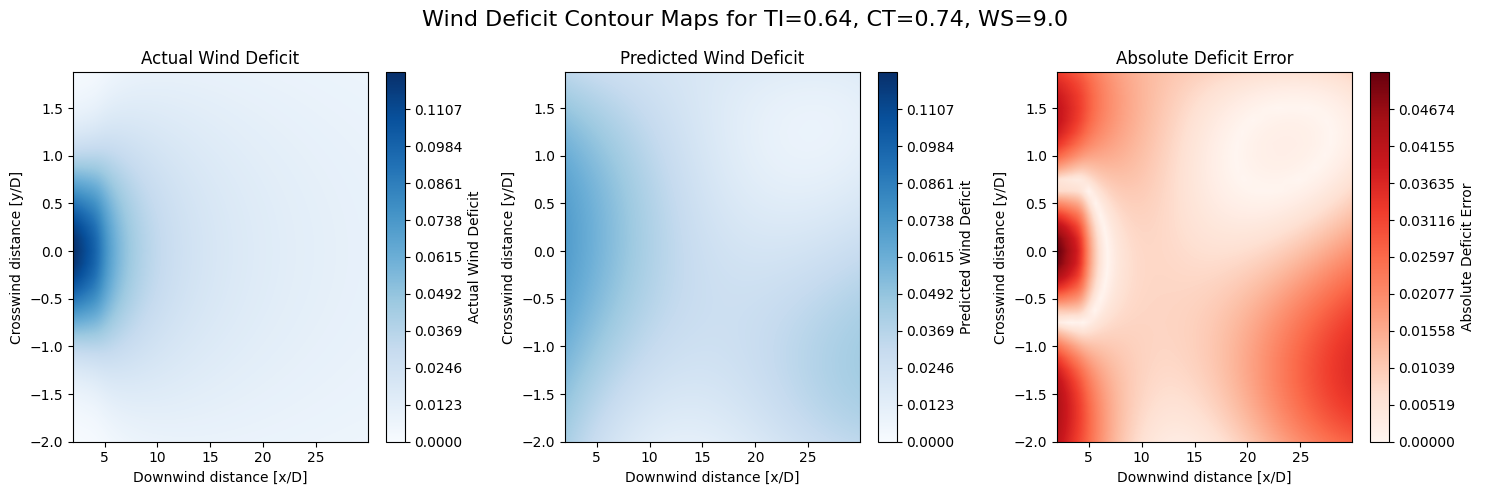

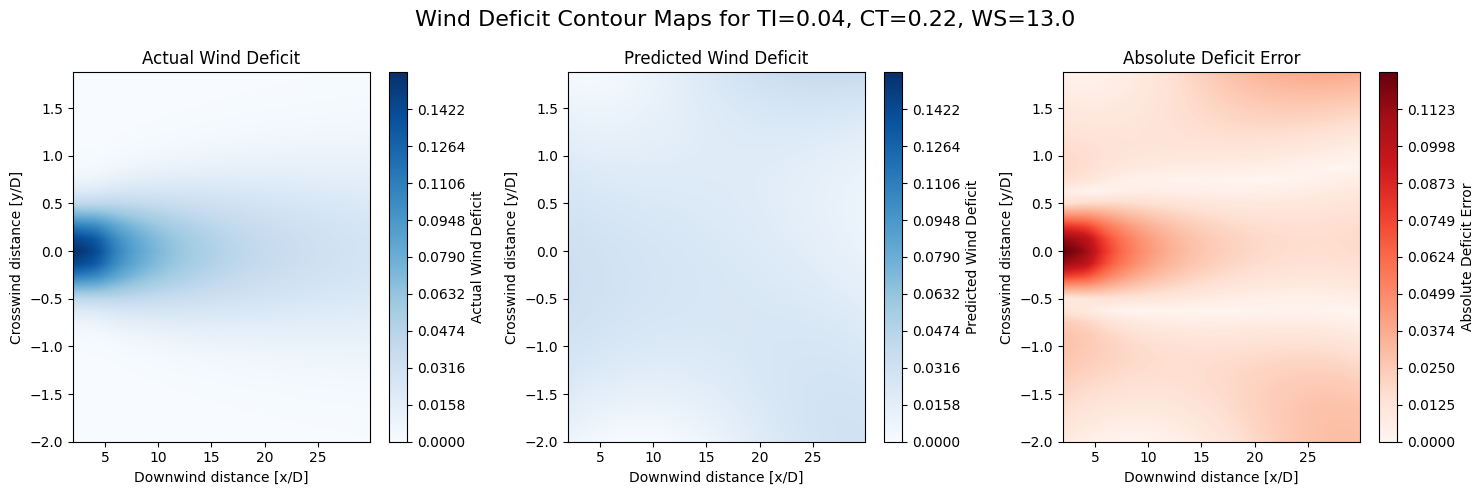

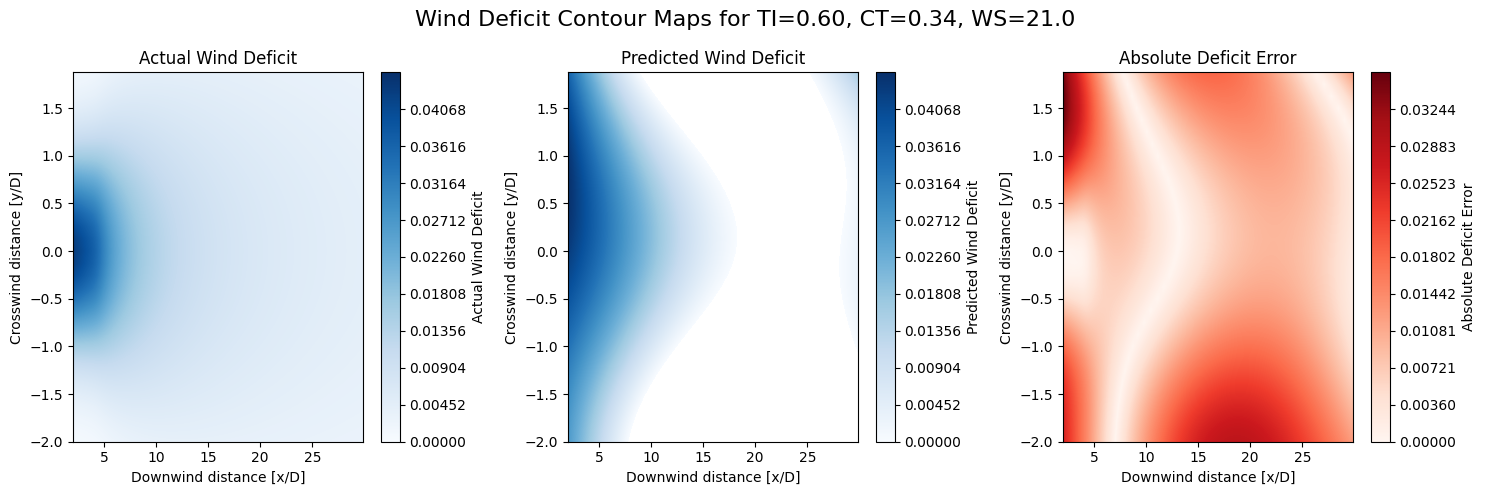

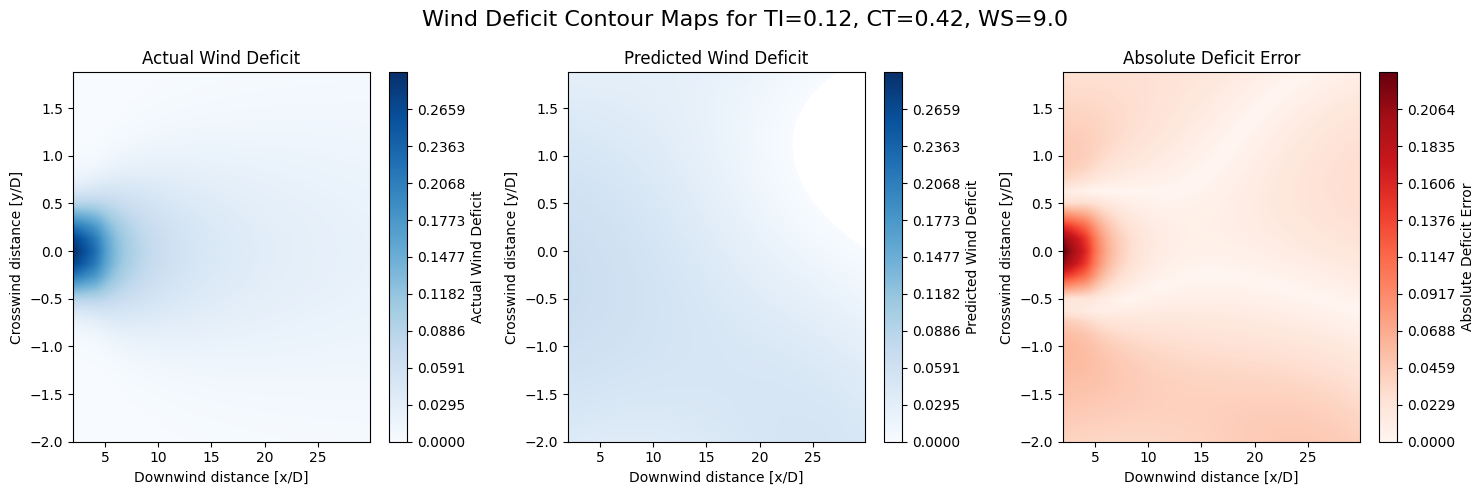

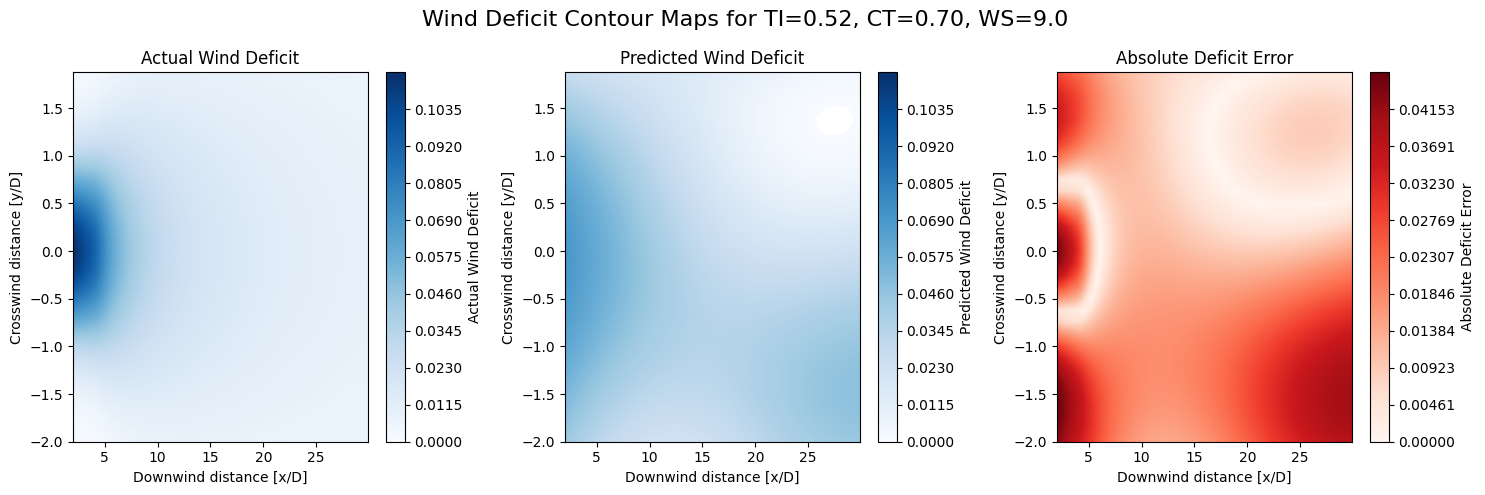

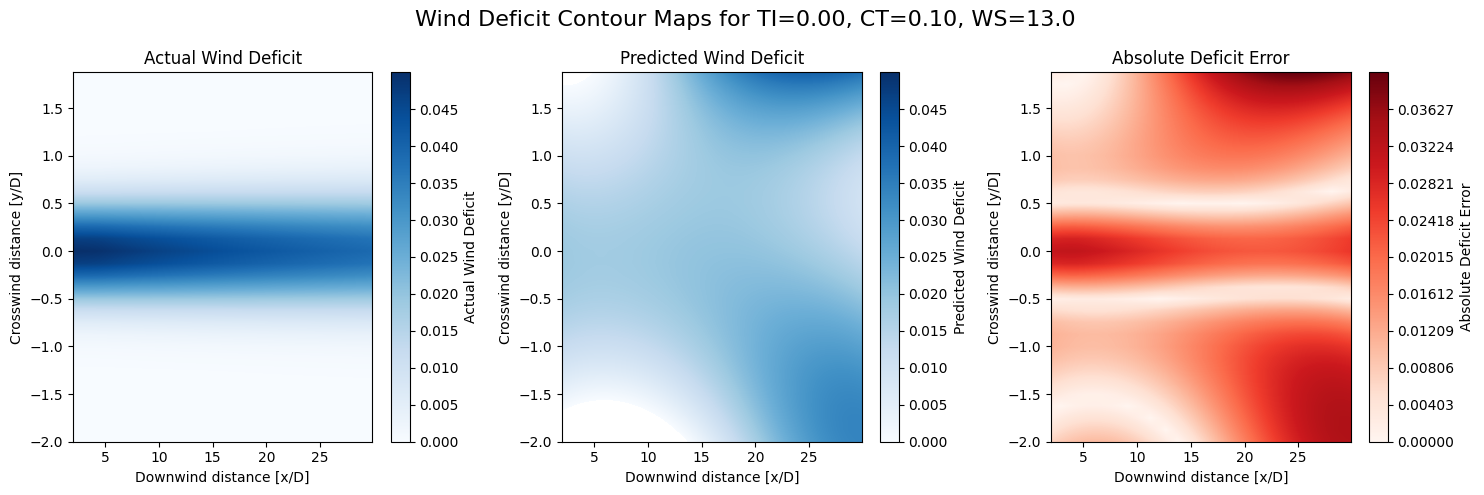

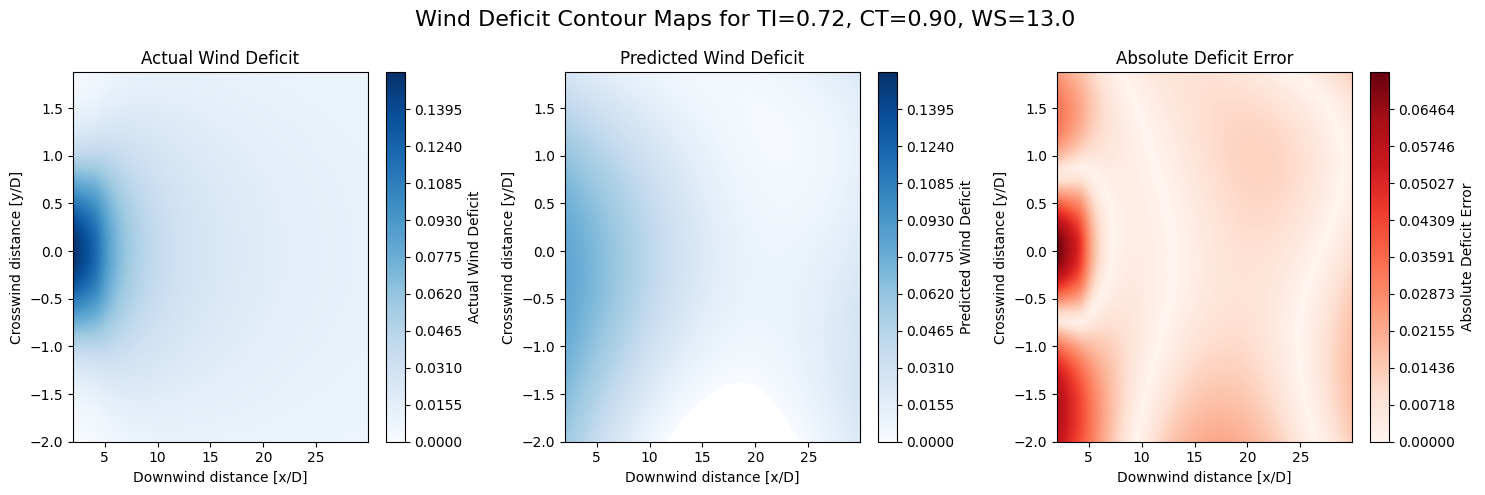

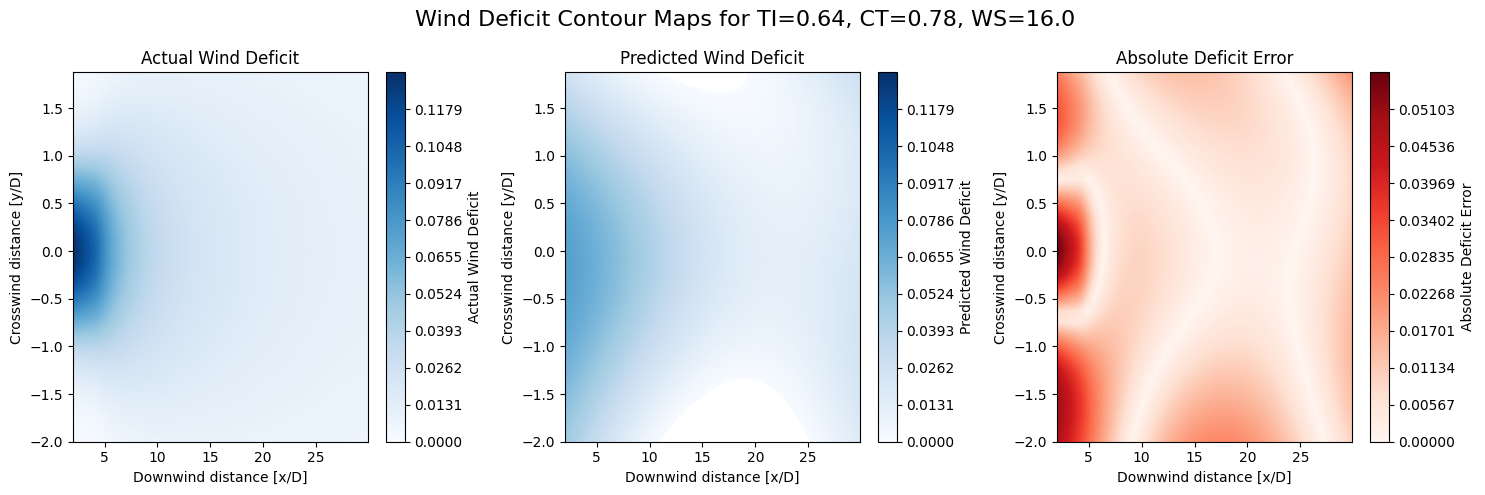

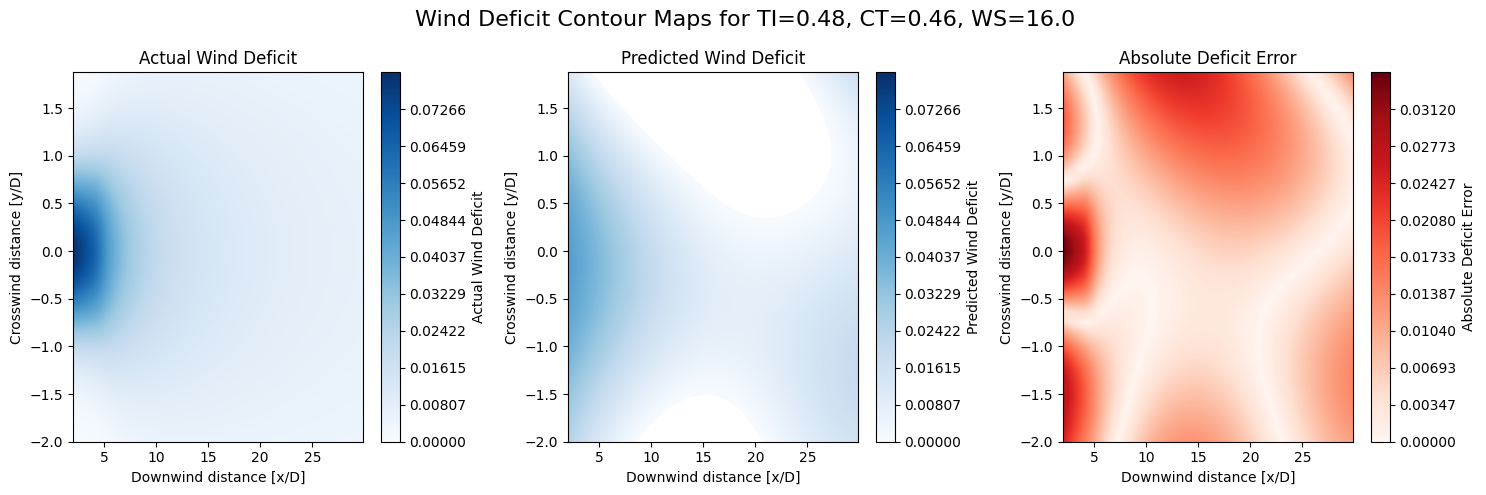

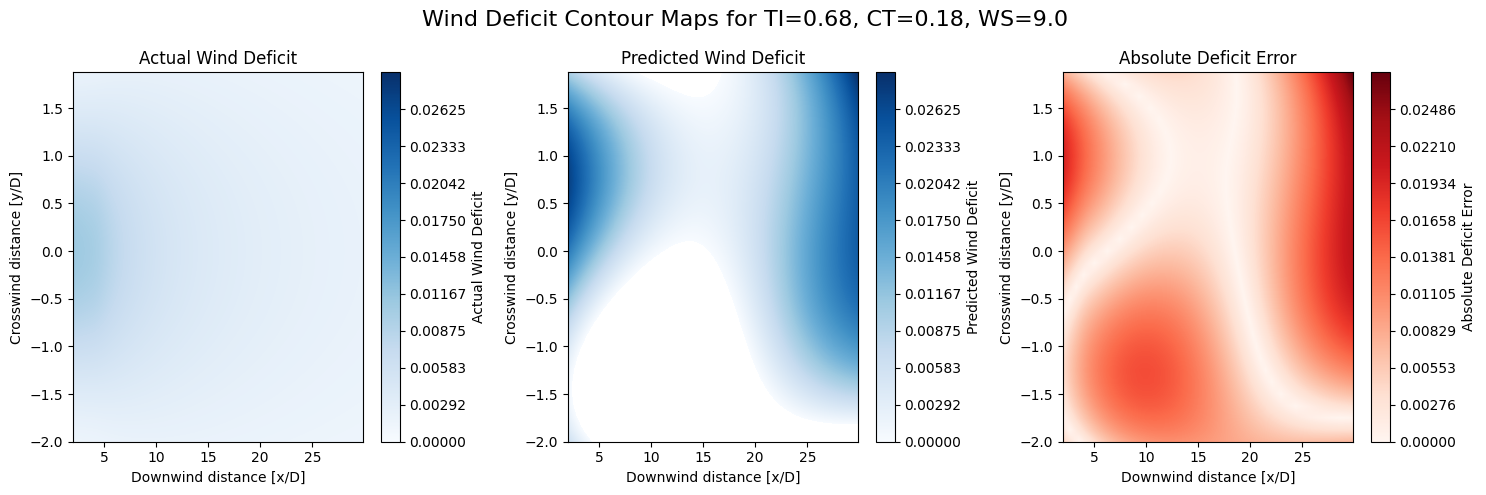

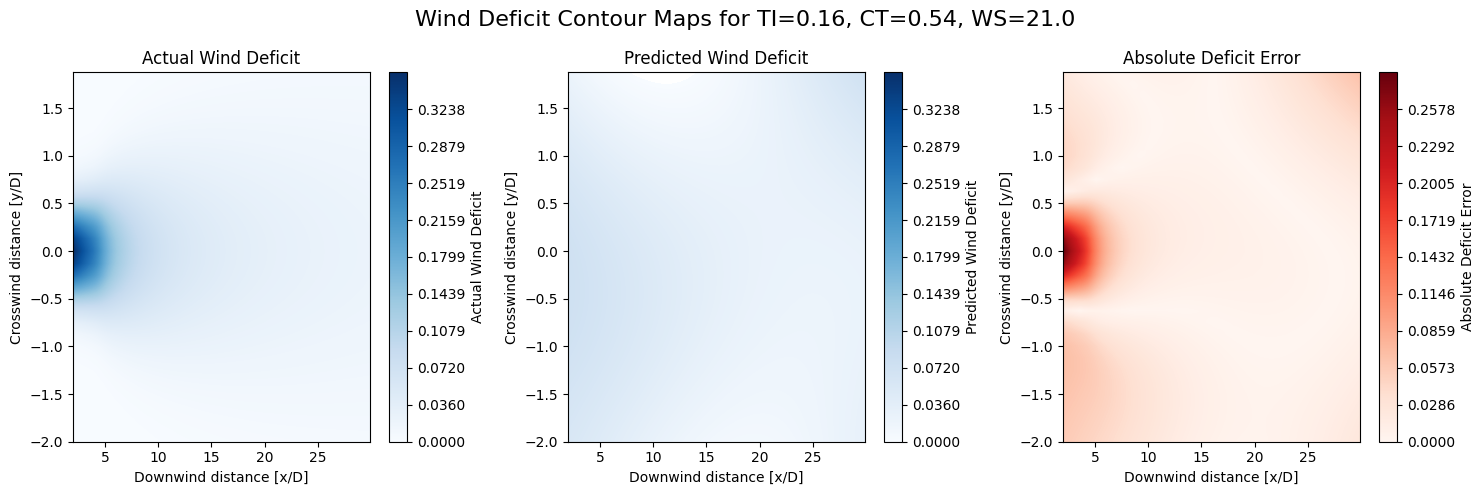

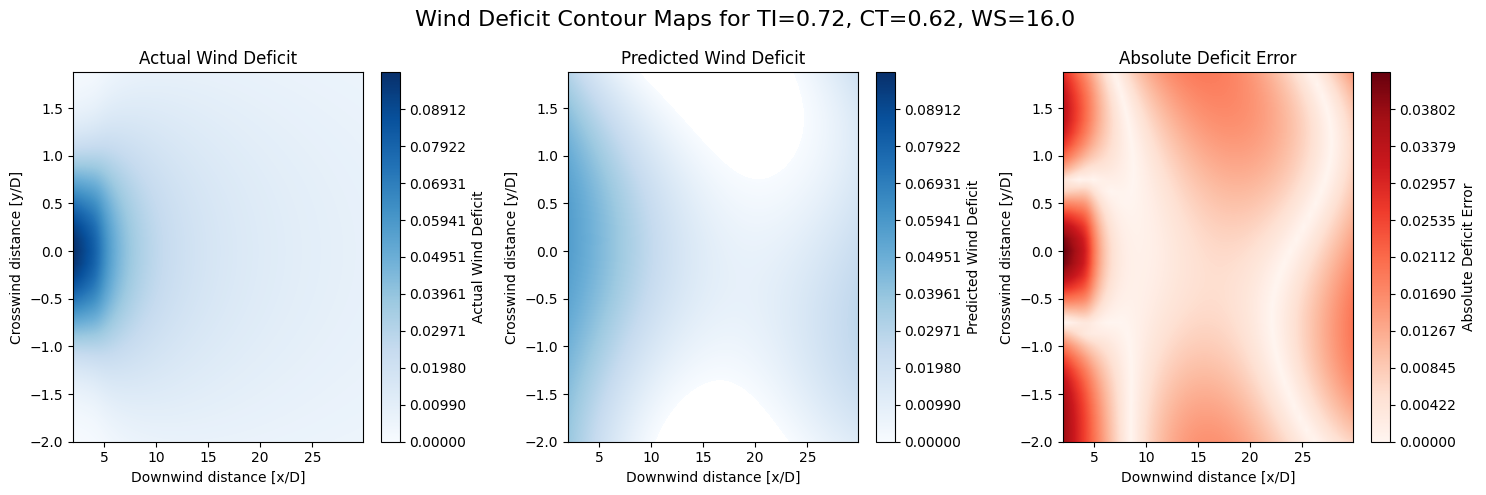

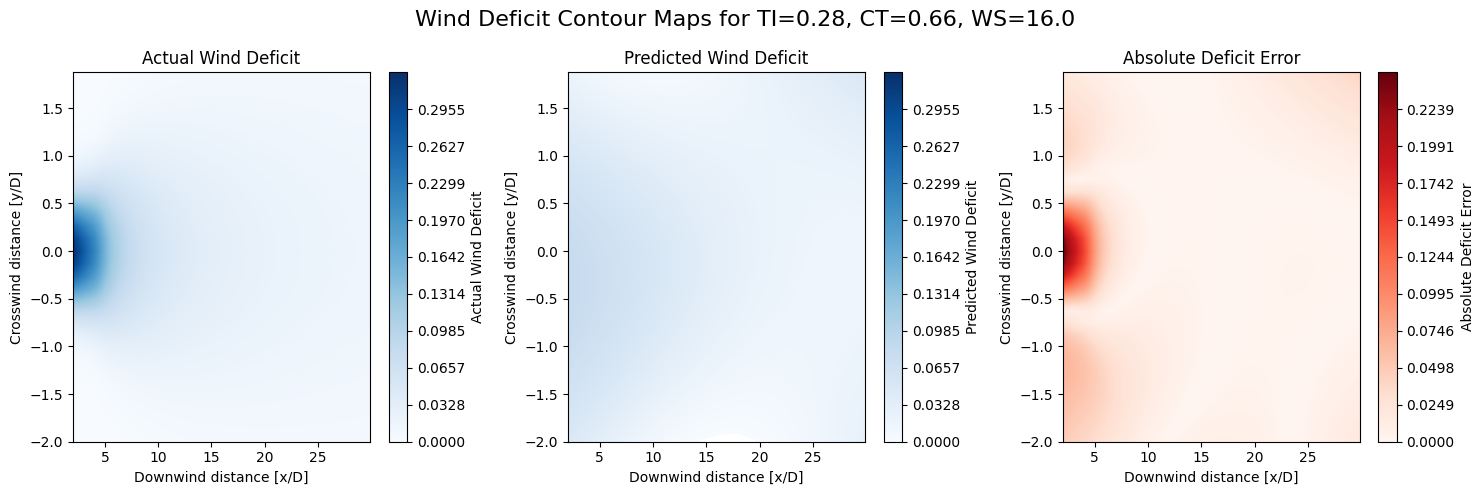

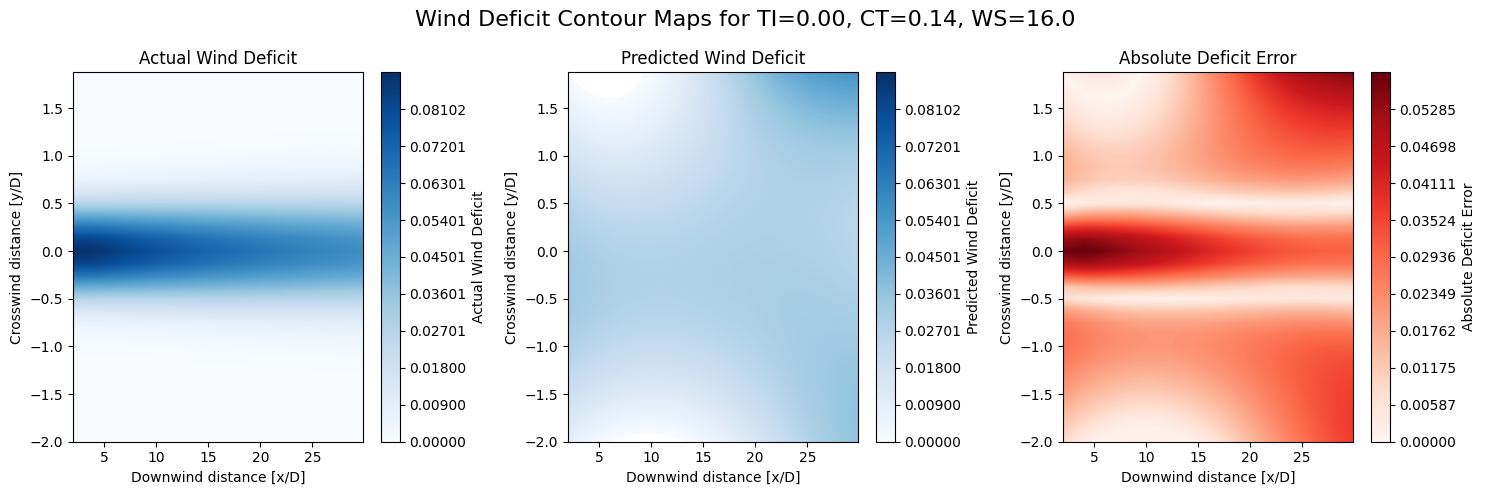

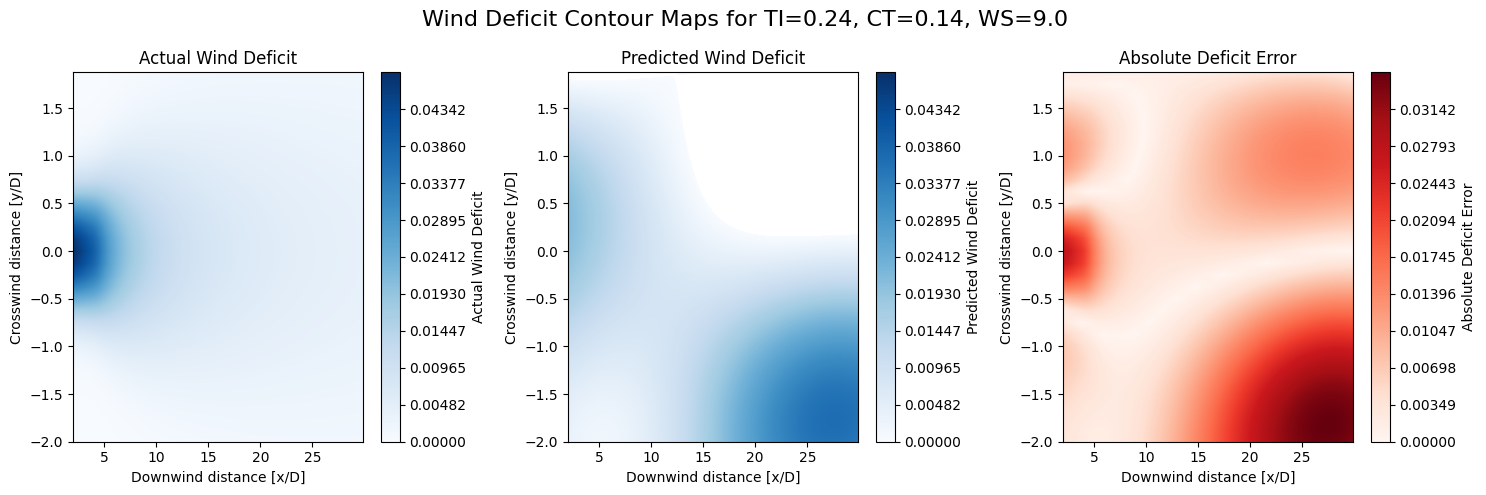

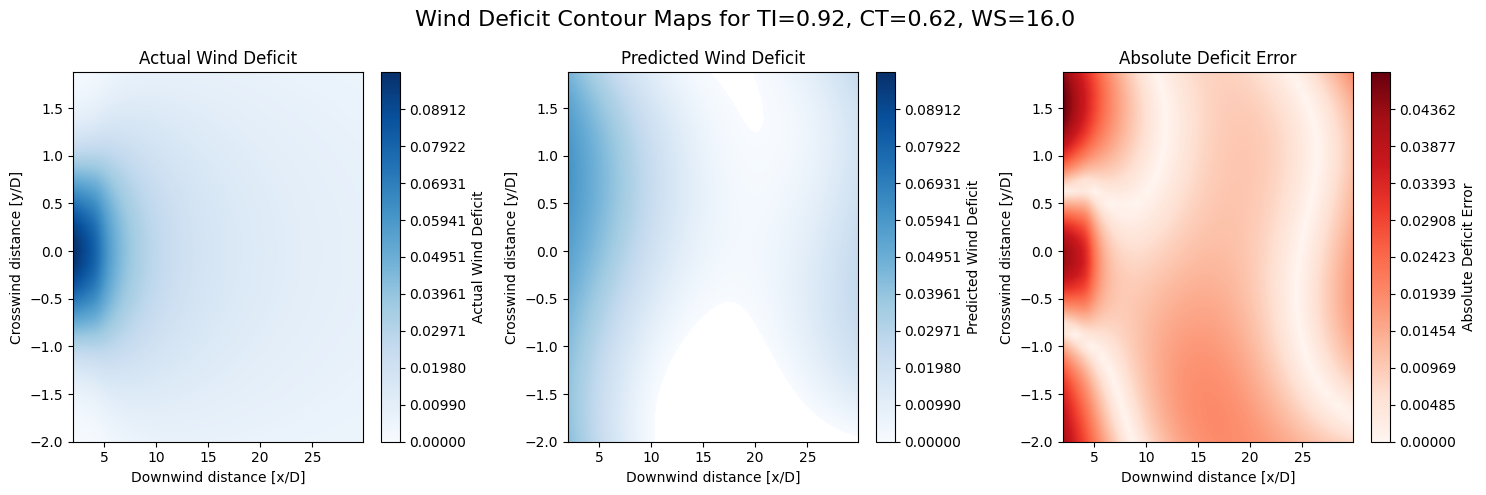

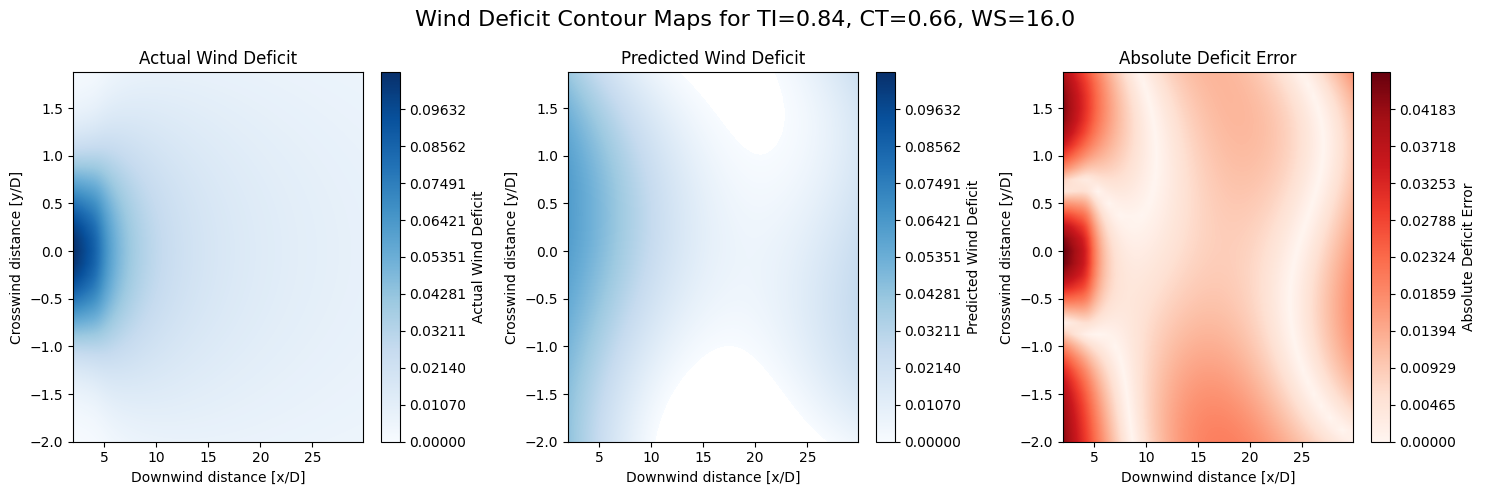

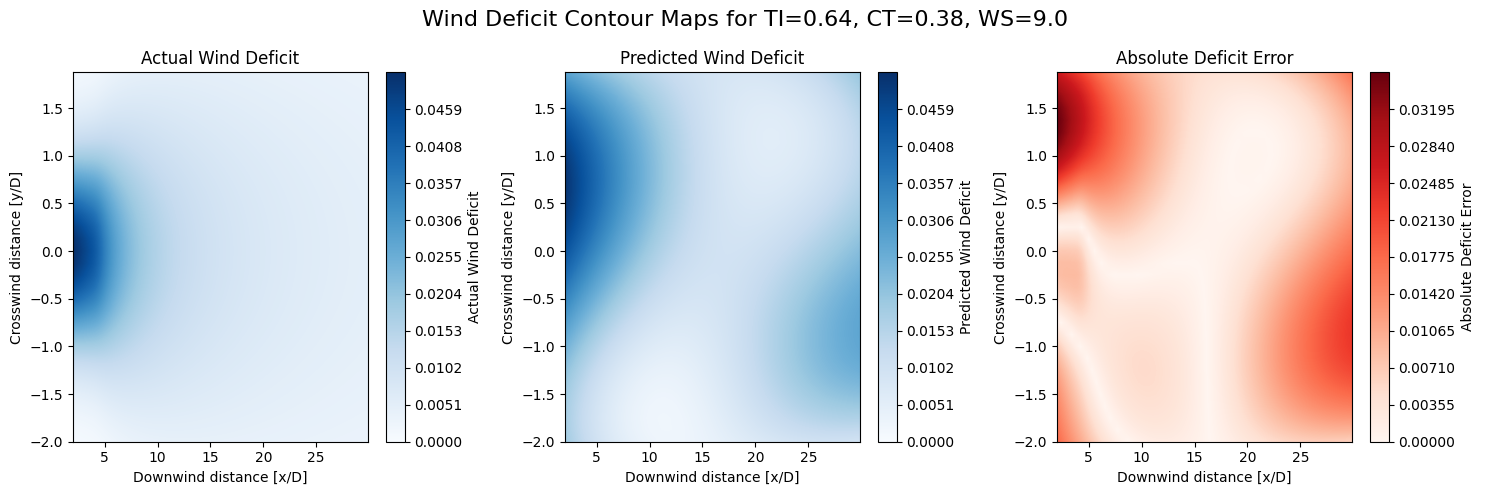

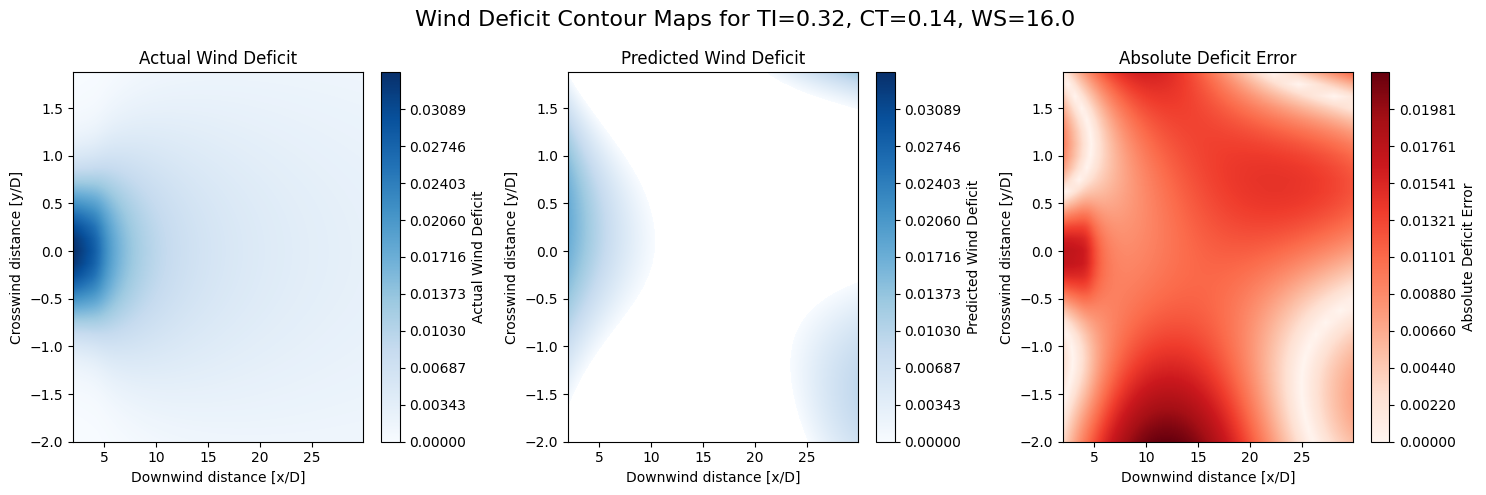

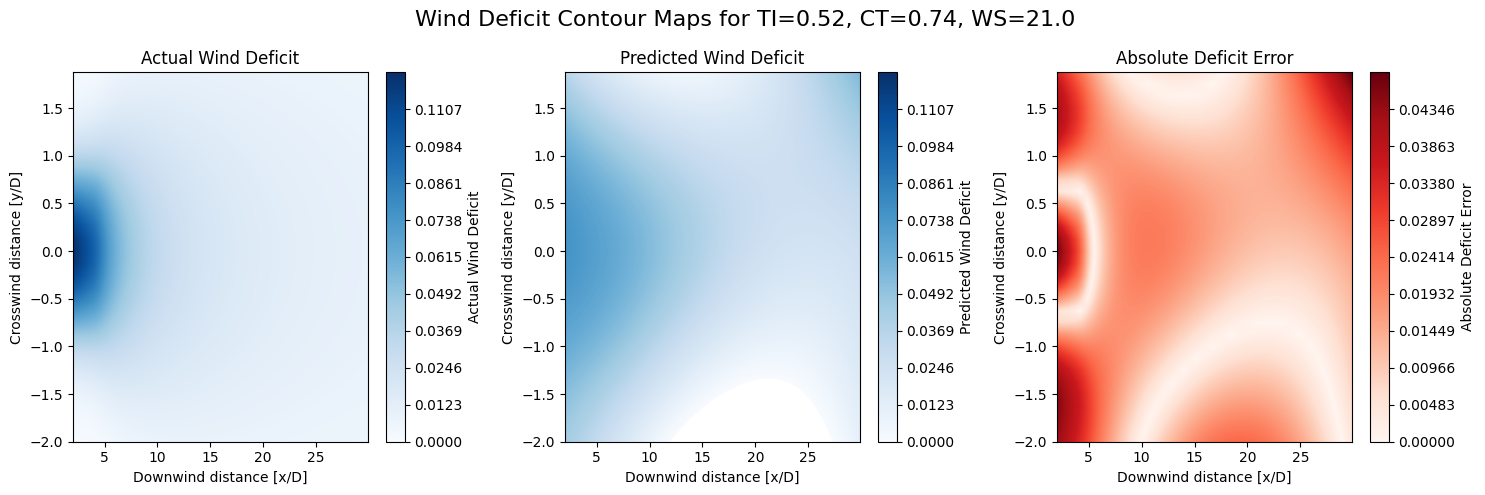

In [9]:
num_cells = test_dataset.num_cells
num_fields = len(test_dataset)//num_cells
field_indices = list(range(num_fields))
random.shuffle(field_indices)

for field_idx in field_indices[:20]: #20 random fields
    inputs, outputs = test_dataset[test_dataset.slice_for_field(field_idx)]
    inputs_fourier = rbf_sampler.transform(inputs)
    ti, ct, ws, wake_field, predicted_wake_field =\
        test_dataset.get_parameters_for_plotting_univariate(model, field_idx, transformed_inputs=inputs_fourier)
    
    plotting.plot_maps(test_dataset.X_grid, test_dataset.Y_grid, wake_field, predicted_wake_field, ti, ct, ws, error_to_plot='absolute')